<a href="https://colab.research.google.com/github/nanopiero/PREAC/blob/main/notebooks/4_Multimodal_Transformer_test_pluvios.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Atelier 4 : Régression multimodale avec un Visual Transformer


In [1]:
# Imports des bibliothèques utiles
# pour l'IA
import torch
# pour les maths
import numpy as np
# pour afficher des images et des courbes
import matplotlib.pyplot as plt

In [2]:
! git clone https://github.com/nanopiero/PREAC.git

fatal: destination path 'PREAC' already exists and is not an empty directory.


## A. Découverte du problème

In [3]:
pip install einops

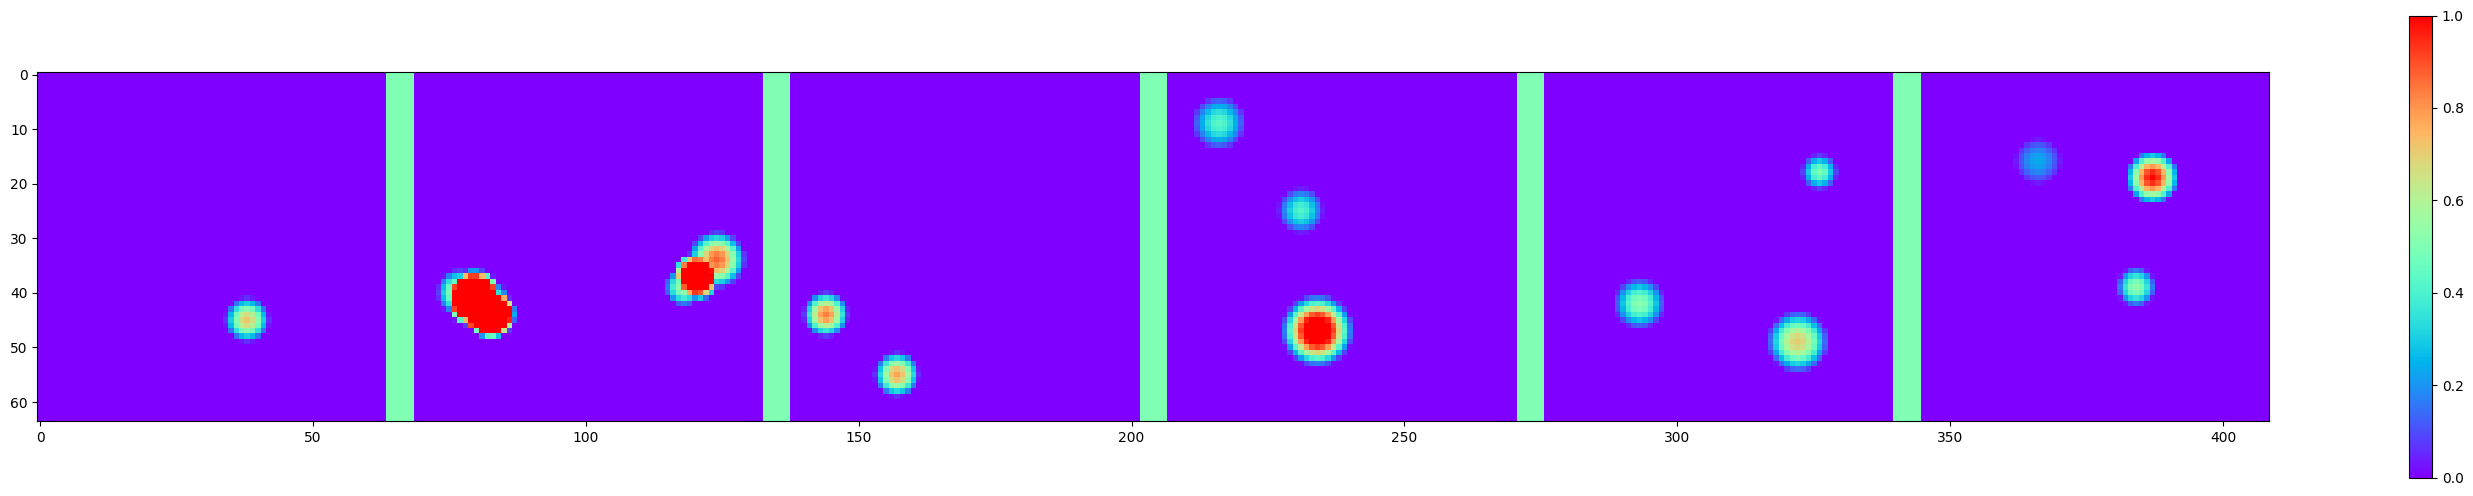

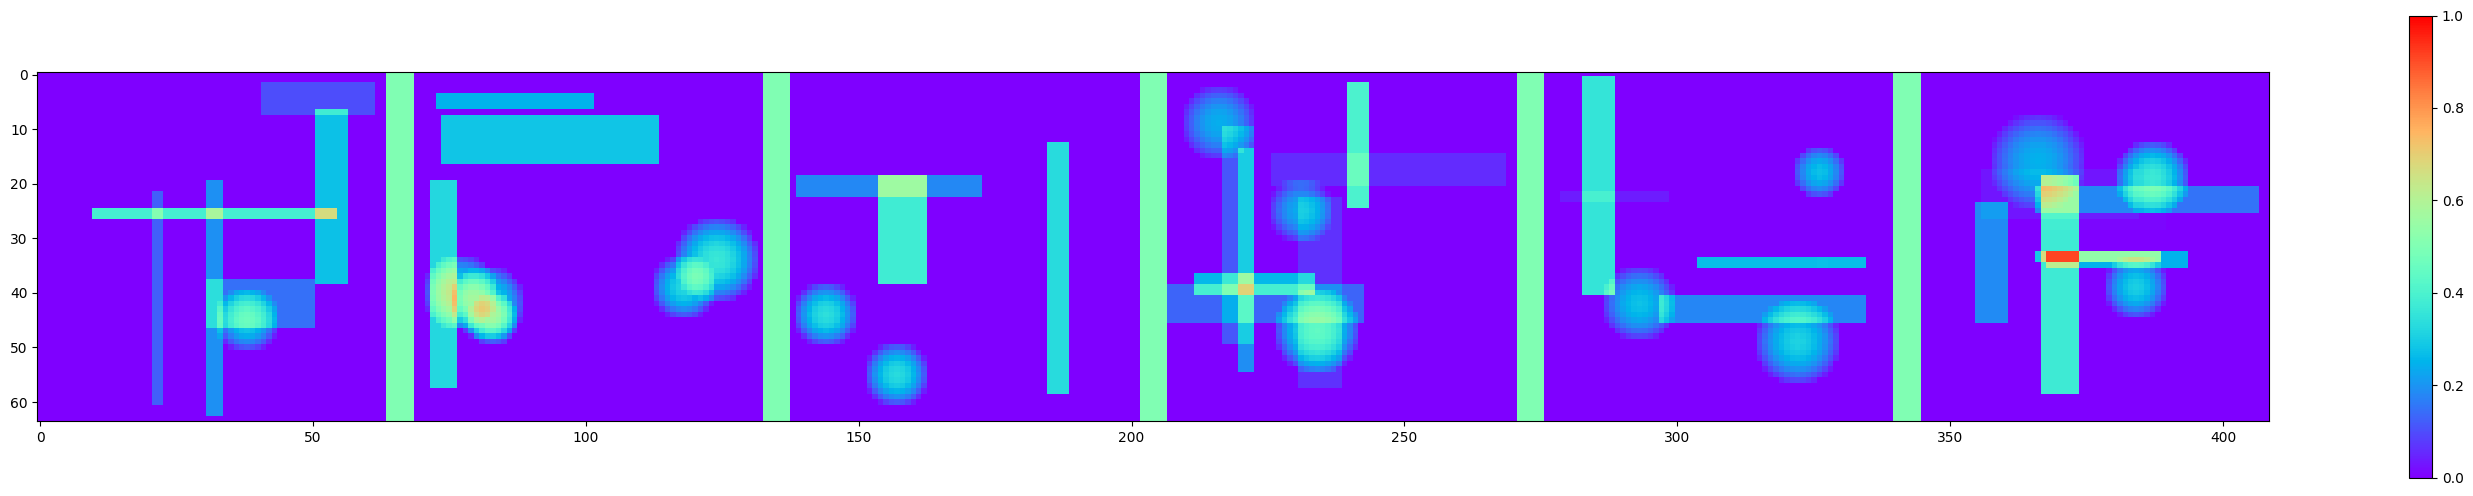

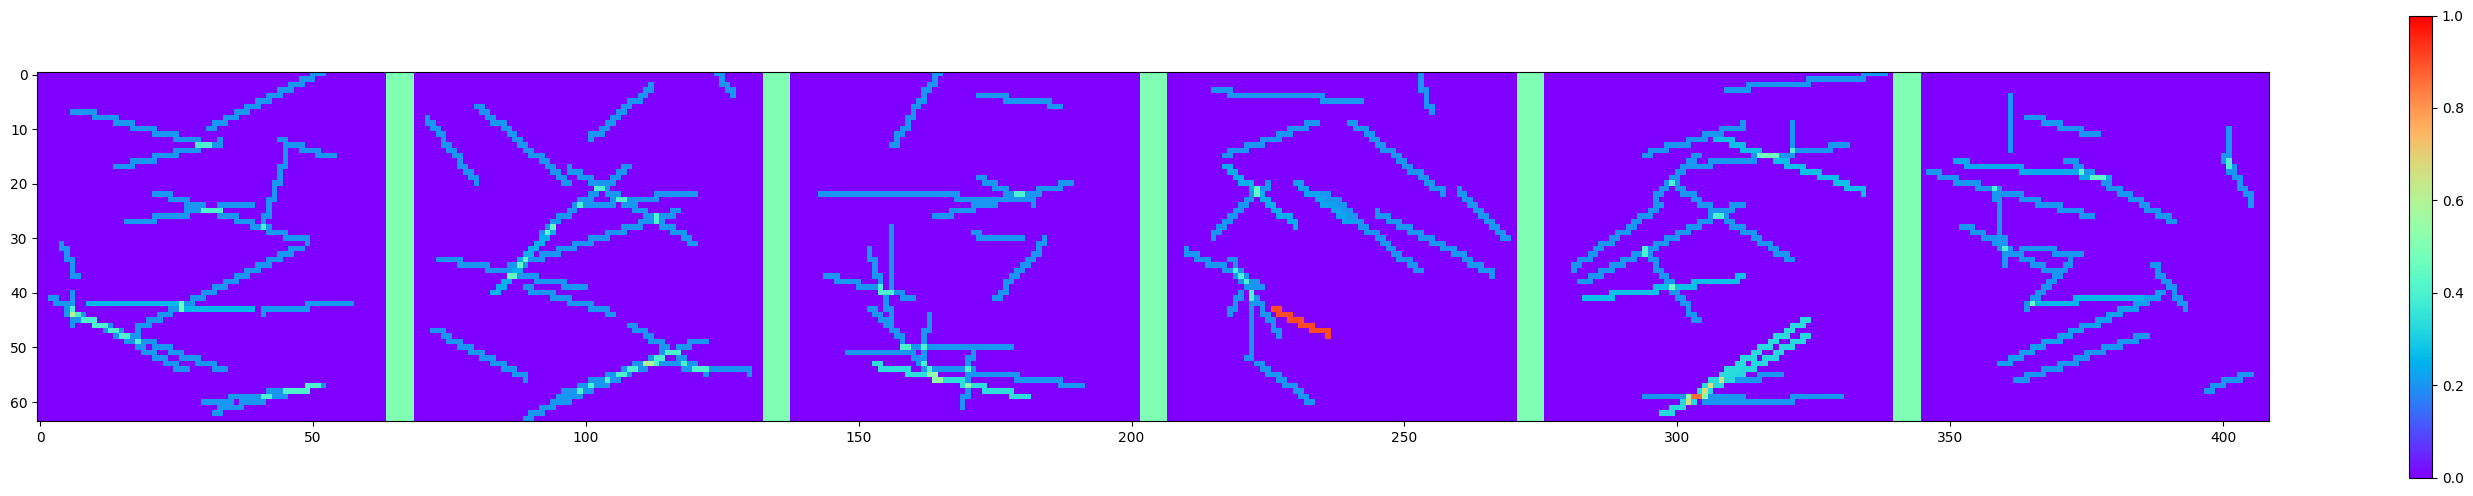

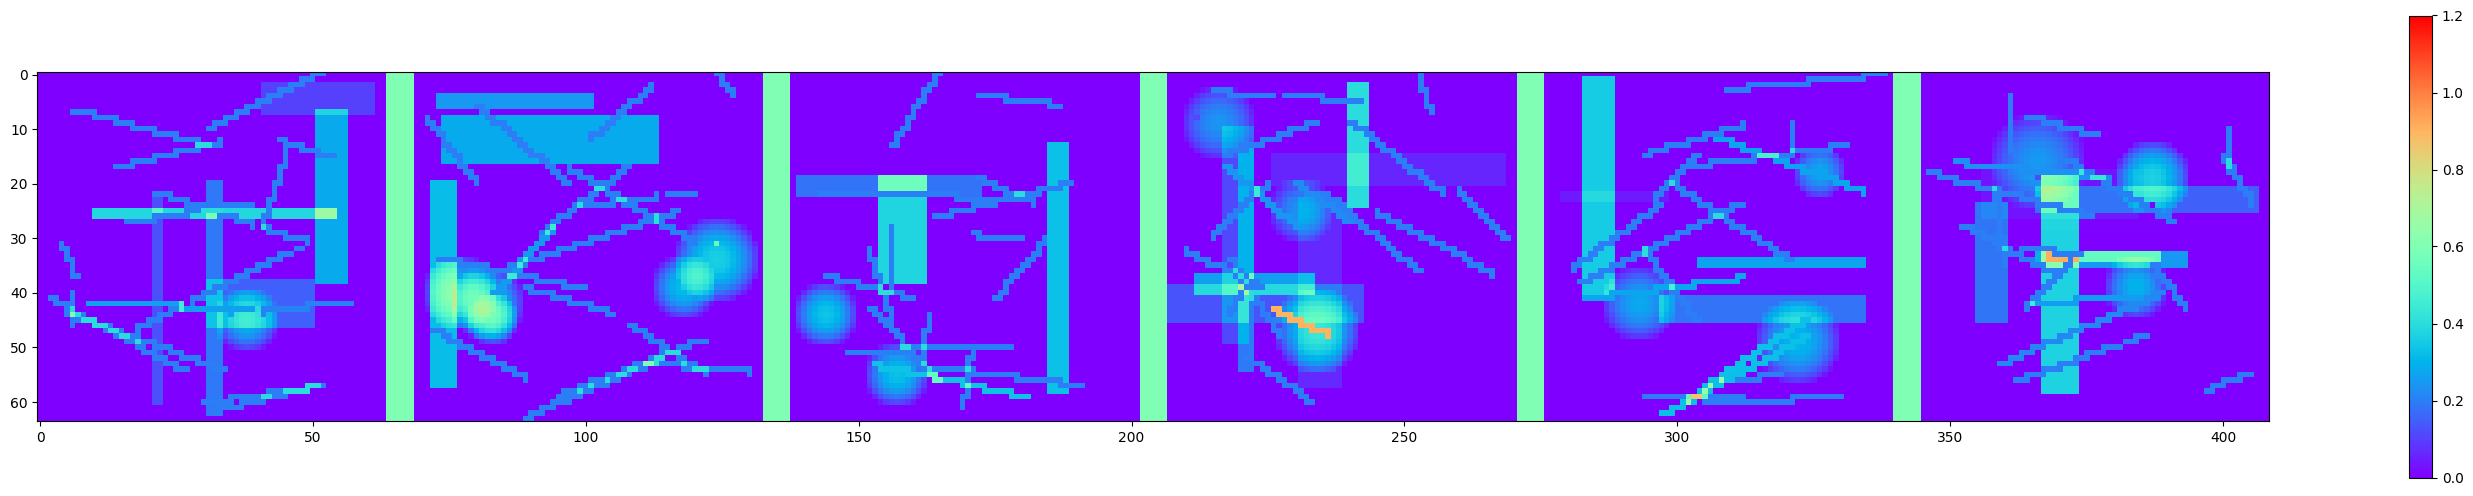

In [4]:
from PREAC.utile_Transformers import voir_batch2D, gen_image_with_pairs, set_tensor_values

# Notre jeu de données contient:
# une cible parfaite (lamedeau)
# des triplets "pluviometres" :
# (lon_pluvio, lat_pluvio, taux de pluie mesuré)
# des quintuplets "cmls" associés aux antennes A & B:
# (lon_A, lat_A, lat_B, lon_B, taux de pluie moyen entre A et B)

batch_size = 6
n_pairs = 16
n_points = 16
lamedeau, pluviometres, radar, cmls_spatialises, cmls = gen_image_with_pairs(6, n_pairs, n_points)

# lame d'eau "idéale"
fig1 = plt.figure(1, figsize=(36, 6))
voir_batch2D(lamedeau, 6, fig1, k=0, min_scale=0, max_scale=1)

# images radar (bruitées)
fig2 = plt.figure(2, figsize=(36, 6))
voir_batch2D(radar, 6, fig2, k=0, min_scale=0, max_scale=1)

# Commercial Microwave Links (cmls)
fig3 = plt.figure(3, figsize=(36, 6))
voir_batch2D(cmls_spatialises, 6, fig3, k=0, min_scale=0, max_scale=1)

# Superposition Commercial Microwave Links (CMLs), pluviomètres et radar
fig4 = plt.figure(4, figsize=(36, 6))
cmls_spatialises = set_tensor_values(cmls_spatialises, pluviometres, 64)
radar[cmls_spatialises > 0] = cmls_spatialises[cmls_spatialises > 0 ]
voir_batch2D(radar, 6, fig4, k=0, min_scale=0., max_scale=1.2)


**Questions intéressantes** : \\
Pourquoi est-ce que le temps de génération des images est long la première fois qu'on lance le code, mais pas les suivantes ? \\
En quoi les cmls et les pluviomètres peuvent-ils aider à atteindre la cible (c'est à dire la lame d'eau complète) ? \\

## B. Traitement par FCN

A partir des ateliers précédents, il est possible de définir
une approche simple permettant de combiner les trois sources d'information.
Seule obstacle : comment concaténer les entrées. D'où le code suivant:

In [5]:
lamedeau, pluviometres, radar, cmls_spatialises, cmls = gen_image_with_pairs(6, n_pairs, n_points)

In [6]:
lamedeau, pluviometres, radar, cmls_spatialises, cmls = gen_image_with_pairs(6, n_pairs, n_points)
pluviometres_spatialises =  -0.1 * torch.ones(radar.shape)
pluviometres_spatialises = set_tensor_values(pluviometres_spatialises, pluviometres, 64)
input = torch.cat([radar, pluviometres_spatialises, cmls_spatialises], dim = 1)
print(input.shape)

torch.Size([6, 3, 64, 64])


**Questions intéressantes** : \\
Pourquoi est-ce qu'on créé une matrice de -0.1 pour les pluviomètres spatialisés ? \\
Comment instancier un UNet pour prendre ce type d'input en entrée ? \\
Visualiser les sorties au bout de cinquante époques (100 batches de 32 par époque).

## C. Encodage des différentes variables qui vont alimenter le transformer

In [7]:
# Paramètres du modèle :
image_size = [64,64]
channels = 1
patch_size = 4
d_model = 120
mlp_expansion_ratio = 4
d_ff = mlp_expansion_ratio * d_model
n_heads = 4
n_layers = 12

In [8]:
# Module interne du réseau responsable de l'encodage des variables :
from PREAC.utile_Transformers import UnifiedEmbedding
ue = UnifiedEmbedding(d_model, patch_size, channels)


In [9]:
lamedeau, pluviometres, radar, cmls_spatialises, cmls = gen_image_with_pairs(6, n_pairs, n_points)
embeddings = ue(radar, pluviometres, cmls)
print(embeddings.shape)

torch.Size([6, 288, 120])


**Question intéressante** : \\
Comment interpréter les dimensions de l'input après encodage ? \\


## D. Entraînement du Transformer

In [10]:
from PREAC.utile_Transformers import FusionTransformer
model = FusionTransformer(image_size, patch_size, n_layers, d_model, d_ff, n_heads, channels=1)
lamedeau, pluviometres, radar, cmls_spatialises, cmls = gen_image_with_pairs(6, n_pairs, n_points)
model(radar, pluviometres, cmls).shape

torch.Size([6, 1, 64, 64])

In [11]:
def criterion(output, target):
    return torch.abs((output - target)).mean()

import torch.optim as optim
optimizer = optim.Adam(model.parameters(), 10**(-4))

In [32]:
f0 = torch.nn.BCELoss()
bce = torch.nn.BCELoss(reduction='none')
m = torch.nn.Sigmoid()

In [37]:
def f1(x, y, alpha = 100.):
  loss = bce(x, y)
  alphat = torch.full_like(y, 1)
  alphat[y==1] = alpha
  loss *= alphat
  return loss.mean()


In [38]:
f1(m(outputs), (pluviometres_spatialises > 0).float())

tensor(0.8638, device='cuda:0', grad_fn=<MeanBackward0>)

In [39]:
nepochs = 50
nbatches = 100
batchsize = 32
train_losses = []
device = torch.device('cuda:0')
model = model.to(device)


for epoch in range(nepochs):
    print(f"Epoch {epoch + 1}/{nepochs}")

    epoch_losses = []

    for i in range(nbatches):
        lamedeau, pluviometres, radar, cmls_spatialises, cmls = gen_image_with_pairs(batchsize, n_pairs, n_points)
        lamedeau, pluviometres, radar, cmls_spatialises, cmls = lamedeau.cuda(), pluviometres.cuda(), radar.cuda(), cmls_spatialises.cuda(), cmls.cuda()
        pluviometres_spatialises = torch.full_like(lamedeau, -0.1)
        pluviometres_spatialises = 0.1 + set_tensor_values(pluviometres_spatialises, pluviometres)

        optimizer.zero_grad()
        outputs = model(radar, pluviometres, cmls)
        loss = f1(m(outputs), (pluviometres_spatialises > 0).float())
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.detach().cpu().item())

    epoch_loss = np.mean(epoch_losses)
    train_losses.append(epoch_loss)

    print(f'Epoch loss: {epoch_loss:.4f}')


Epoch 1/50
Epoch loss: 0.8501
Epoch 2/50
Epoch loss: 0.8357
Epoch 3/50
Epoch loss: 0.8299
Epoch 4/50
Epoch loss: 0.8270
Epoch 5/50
Epoch loss: 0.8253
Epoch 6/50
Epoch loss: 0.8246
Epoch 7/50
Epoch loss: 0.8242
Epoch 8/50
Epoch loss: 0.8240
Epoch 9/50
Epoch loss: 0.8237
Epoch 10/50
Epoch loss: 0.8239
Epoch 11/50
Epoch loss: 0.8238
Epoch 12/50
Epoch loss: 0.8237
Epoch 13/50
Epoch loss: 0.8236
Epoch 14/50
Epoch loss: 0.8237
Epoch 15/50
Epoch loss: 0.8237
Epoch 16/50
Epoch loss: 0.8237
Epoch 17/50
Epoch loss: 0.8236
Epoch 18/50
Epoch loss: 0.8237
Epoch 19/50
Epoch loss: 0.8237
Epoch 20/50
Epoch loss: 0.8244
Epoch 21/50
Epoch loss: 0.8247
Epoch 22/50
Epoch loss: 0.8239
Epoch 23/50
Epoch loss: 0.8237
Epoch 24/50
Epoch loss: 0.8237
Epoch 25/50
Epoch loss: 0.8236
Epoch 26/50
Epoch loss: 0.8237
Epoch 27/50
Epoch loss: 0.8237
Epoch 28/50


KeyboardInterrupt: 

**Questions intéressantes** : \\
Quelle différence qualitative entre les outputs ? \\
Que doit faire le transformer "en plus", comparé au FCN ?



## E. Chargement d'un Transformer entraîné

In [ ]:
# Avec France Transfert ??
# !curl 'https://francetransfert.numerique.gouv.fr/api-private/download-module/generate-download-url' -X POST \
# -H 'Content-Type: application/json' \
# -H 'Origin:https://francetransfert.numerique.gouv.fr' \
# --data-raw '{"enclosure":"164ea132-cf5e-4a8d-a084-62841b3122ec","recipient":"cGllcnJlLmxlcGV0aXRAbWV0ZW8uZnI%3D","token":"ddf68980-7b19-4eef-8a34-88a3e32a0f71","senderToken":null,"password":"2q*vbl62!FK@Z"}'

In [ ]:
# Modèles entraînés sur 900 époques :
# mViT_900ep.pth comme au D.
# mViT_0radar_900ep.pth avec, au préalable: radar = 0 x radar
! wget https://www.grosfichiers.com/K3aaxZcSnX4_Fic8rPjJ9yZ
! unzip K3aaxZcSnX4_Fic8rPjJ9yZ
! rm K3aaxZcSnX4_Fic8rPjJ9yZ

In [ ]:
# charger un checkpoint avec torch .load
# visualiser les outputs

checkpoint = torch.load('mViT_900ep.pth')
model.load_state_dict(checkpoint['model_state_dict'])

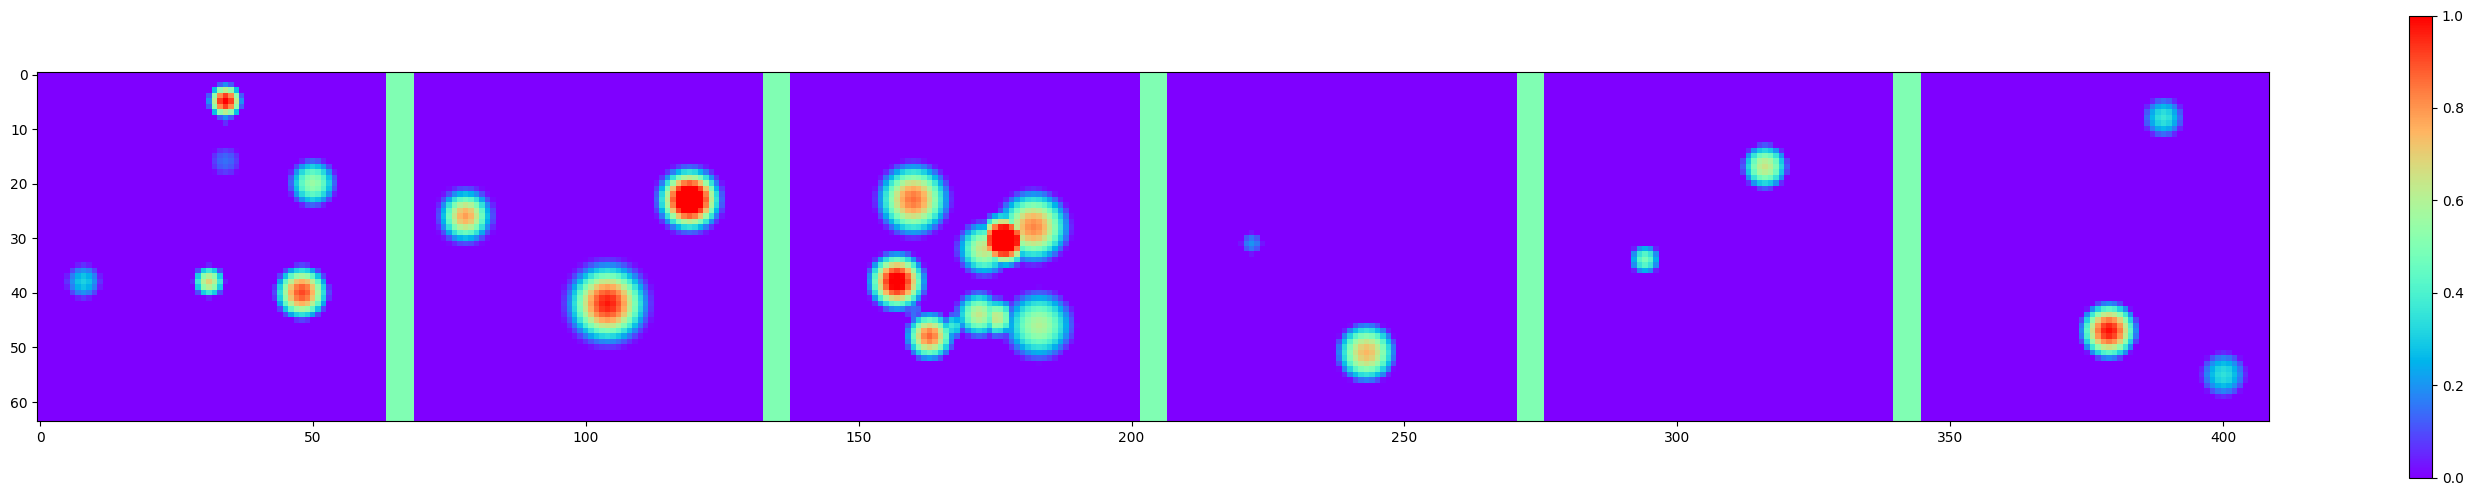

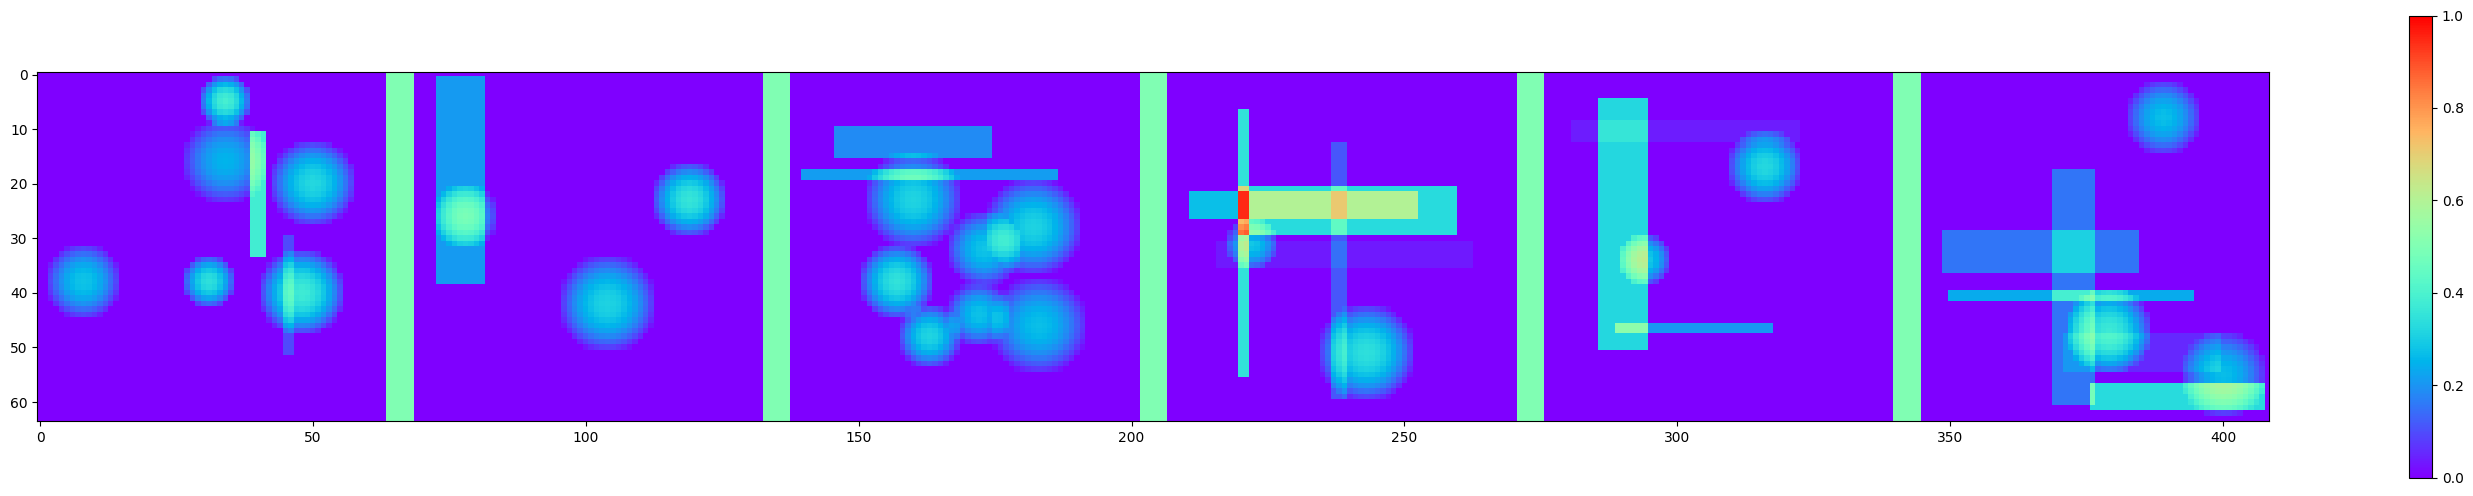

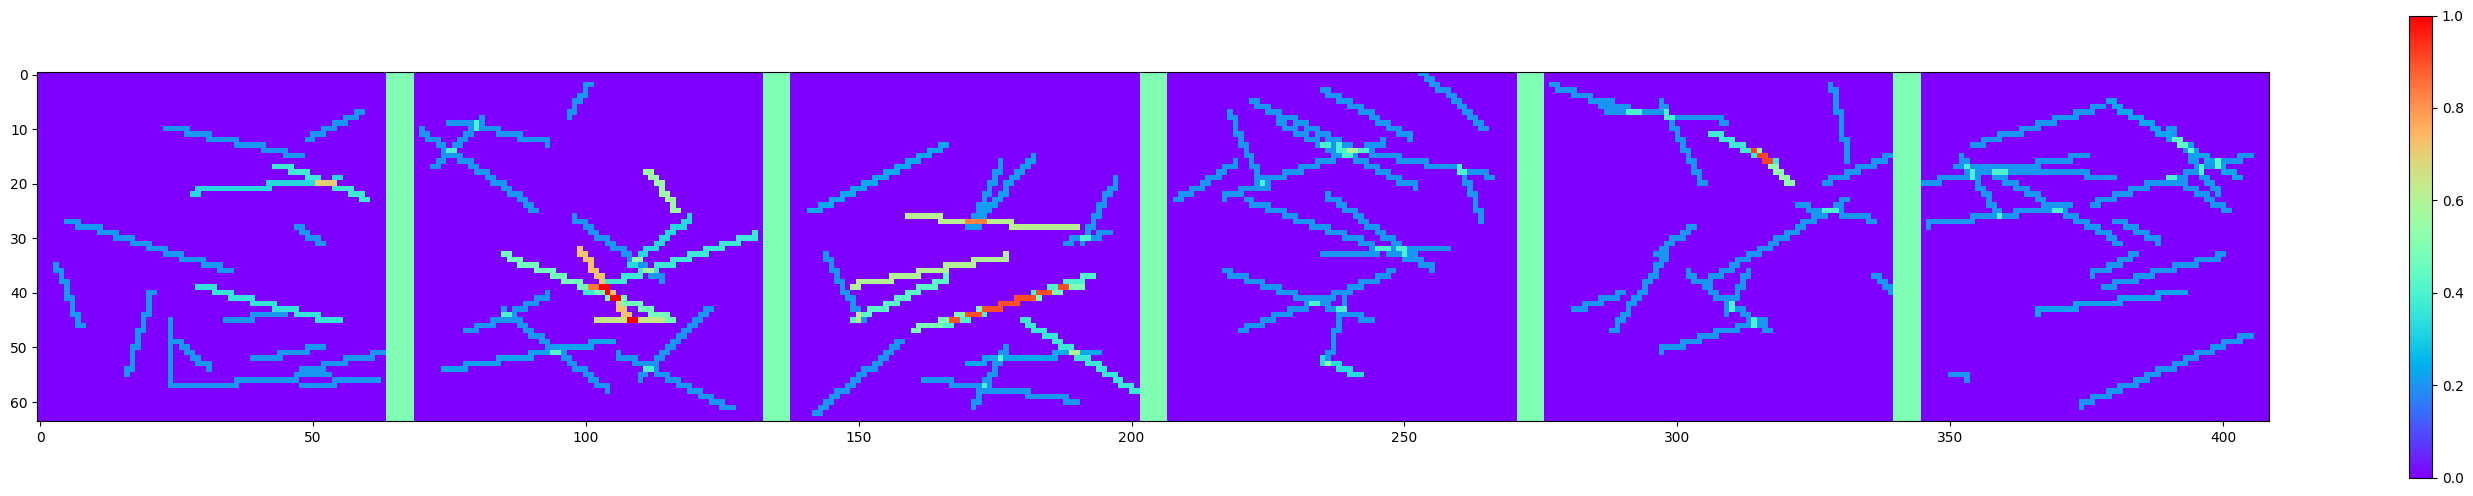

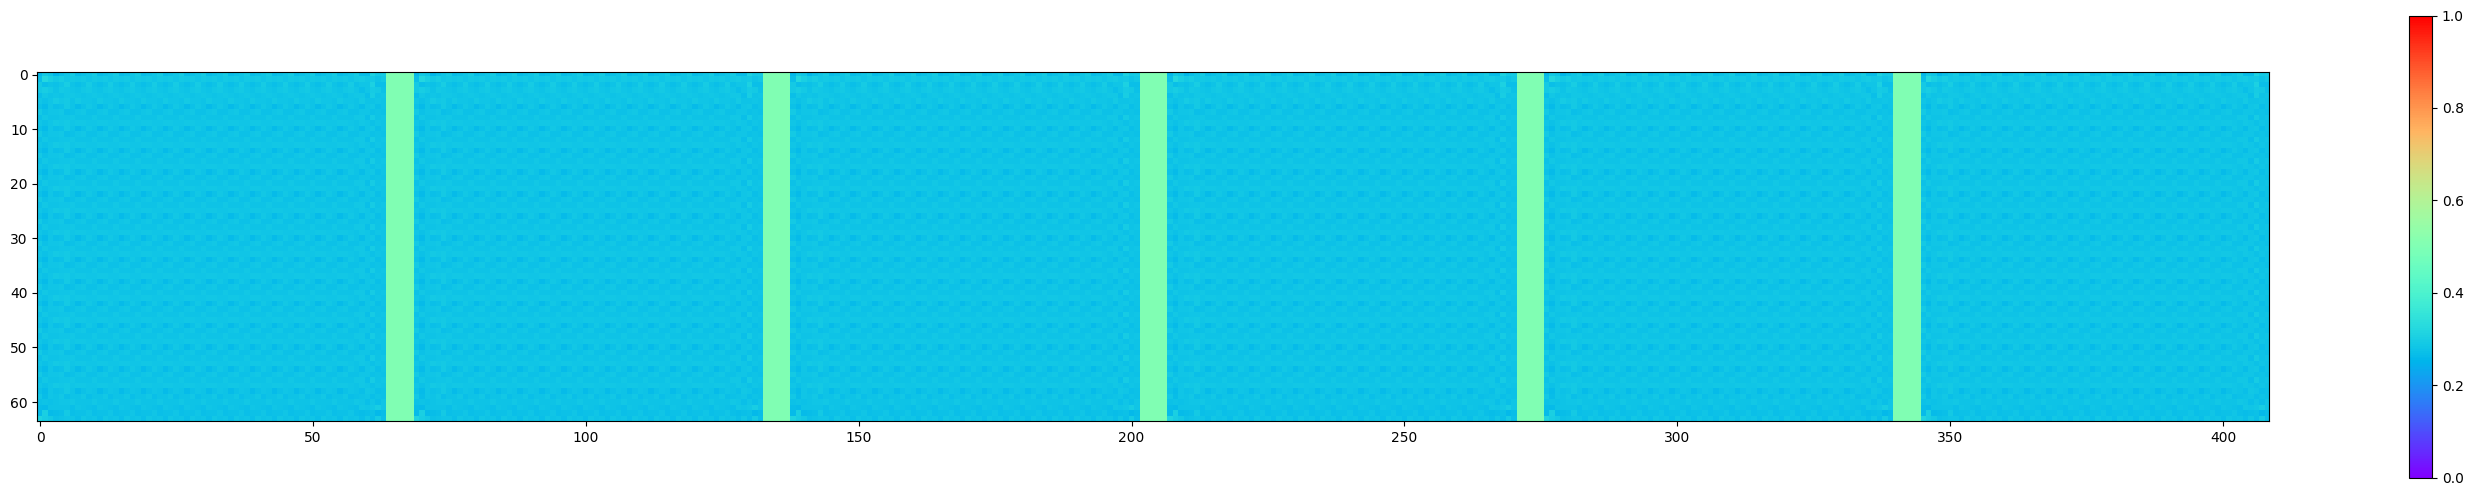

In [40]:
#visualization:

model.eval()

full_target, partial_target, noisy_images, traces, pairs_list = gen_image_with_pairs(6, n_pairs, n_points)
lamedeau, pluviometres, radar, cmls_spatialises, cmls = gen_image_with_pairs(6, n_pairs, n_points)


radar = radar.to(device)
cmls = cmls.to(device)
pluviometres = pluviometres.to(device)
pluviometres_spatialises = torch.full_like(lamedeau, -0.1)
pluviometres_spatialises = 0.1 + set_tensor_values(pluviometres_spatialises, pluviometres)

outputs = model(radar, pluviometres, cmls)

radar = radar.cpu()
cmls = cmls.cpu()
pluviometres = pluviometres.cpu()
outputs = outputs.cpu().detach()

# lame d'eau "idéale"
fig1 = plt.figure(1, figsize=(36, 6))
voir_batch2D(lamedeau, 6, fig1, k=0, min_scale=0, max_scale=1)

# images radar (bruitées)
fig2 = plt.figure(2, figsize=(36, 6))
voir_batch2D(radar, 6, fig2, k=0, min_scale=0, max_scale=1)

# Commercial Microwave Links (cmls)
fig3 = plt.figure(3, figsize=(36, 6))
voir_batch2D(cmls_spatialises, 6, fig3, k=0, min_scale=0, max_scale=1)

# Superposition Commercial Microwave Links (CMLs), pluviomètres et radar
fig3 = plt.figure(3, figsize=(36, 6))
voir_batch2D(m(outputs), 6, fig3, k=0, min_scale=0, max_scale=1)



**Question intéressante** : \\
Le transformer parvient-il à exploiter les valeurs de pluviomètres et des cmls  ?

Bibliographie :  [Jaegle et al. 2020](https://arxiv.org/abs/1811.12739)